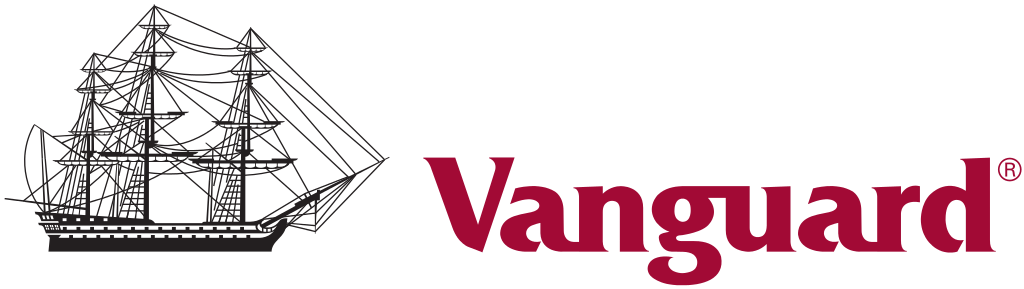

<h1 style="color: #8B2331;">VANGUARD A/B Testing -  Statistical Analysis</h1>

<h1 style="color: #8B2331;">0 | Libraries and Dataset</h1>

In [4]:
# Data Manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Statistical Analysis
import statsmodels.api as sm
from scipy.stats import stats, kurtosis, chi2_contingency
from scipy.stats import probplot, chi2_contingency,ttest_ind
from scipy.stats.contingency import association
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline  

# Show all columns in pandas
pd.set_option('display.max_columns', None)

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_pickle("clean_vanguard.pkl")

<h1 style="color: #8B2331;">1a | Hypothesis Completion Rates (Standard Comparison)</h1>

#####	 H₀ :  completion_rate_test  = completion_rate_control

#####	 H₁ :  completion_rate_test != completion_rate_control

#####    Significance Level:  alpha = 0.05

##### Two-tailed two-proportion z-test.

In [8]:
# divide the number of users who reached “4_confirm” by the unique users in each group (session_id).
confirm_df = df[df['process_step'] == '4_confirm']

total_users = df.groupby('control_test')['session_id'].nunique()
confirm_users = confirm_df.groupby('control_test')['session_id'].nunique()

completion_rate = (confirm_users / total_users) * 100

total_users_control = total_users['Control']
total_users_test = total_users['Test']

confirm_users_control = confirm_users['Control']
confirm_users_test = confirm_users['Test']

print("\nCompletion Rate (%):\n", completion_rate.round(2))


Completion Rate (%):
 control_test
Control    49.85
Test       58.52
Name: session_id, dtype: float64


In [9]:
counts = [confirm_users_test, confirm_users_control]  # counts of completions

nobs = [total_users_test, total_users_control]        # total participants

z_stat, p_value = proportions_ztest(count=counts, nobs=nobs, alternative='two-sided')  # two-proportion z-test

print(f"\nZ-Statistic: {z_stat:.4f}")
print(f"P-Value: {p_value:.4e}")  


Z-Statistic: 22.8568
P-Value: 1.2495e-115


<h1 style="color: #8B2331;">1b: Hypothesis Completion Rates (Cost-Effectiveness Threshold)</h1>

#####	 H₀ :  completion_rate_test <= completion_rate_control + 5%

#####	 H₁ :  completion_rate_test > completion_rate_control + 5%

##### Significance Level:  alpha = 0.05

##### One-tailed two-proportion z-test.

In [12]:
z_stat_threshold, p_value_threshold = proportions_ztest(   # One-sided z-test for threshold (difference of 0.05)
    count=counts,
    nobs=nobs,
    value=0.05,            # Difference under null hypothesis
    alternative='larger'   # Test if Test group > Control group + 5%
)
print(f"\nZ-Statistic (Threshold): {z_stat_threshold:.4f}")
print(f"P-Value (Threshold): {p_value_threshold:.4e}")


Z-Statistic (Threshold): 9.6723
P-Value (Threshold): 1.9779e-22


<h2 style="color: #8B2331;">H1 Interpretation</h2>

### Z-Statistic:

A z-statistic of 22.8568 or 9.6723 corresponds to an incredibly low probability under the null hypothesis. These results provide strong evidence that the new design significantly improves completion rates over the old design, even when accounting for the additional 5% threshold.

### P-Value:

Both P-values (regular and threshold) indicate that the null hypotheses can be rejected with near certainty. For practical purposes, this means the Test group’s UI is much more effective than the Control group’s UI, even with the cost-effectiveness adjustment.

### Why Are Both P-Values So Small?

The dataset likely has a large sample size. In hypothesis testing, larger sample sizes reduce variability in the estimates, which can amplify the Z-statistic and make even small differences statistically significant.

The actual difference between 49.85 and 58.52% might not feel dramatic. However, with many users, even small improvements can yield extremely low p -values, as the confidence in the observed difference grows.

### Statistical Significance:
The new design (Test group) performs better than the old design (Control group), and the results are statistically significant even when requiring a 5% improvement threshold.

### Practical Significance:
While the statistical results are clear, consider the real-world impact of this  8.67\%  improvement. Does it justify the cost of implementing the new design? This would depend on factors like:
- Business goals
- Expected ROI
- User experience metrics

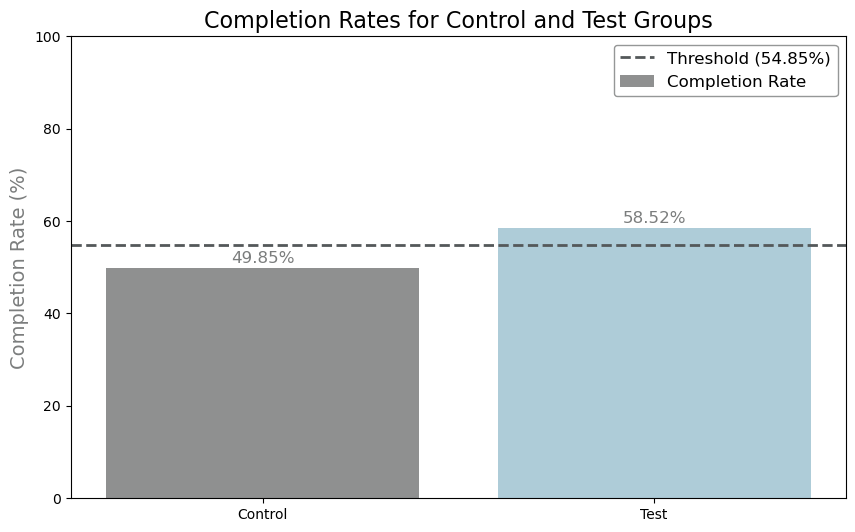

In [15]:
p_control = 0.4985  # Completion rate for Control group 
p_test = 0.5852     # Completion rate for Test group

vanguard_red = "#A0C3D2"       # red "#870619"
vanguard_gray = "#7B7D7D"
vanguard_light_gray = "#54585A"       

groups = ['Control', 'Test']
completion_rates = [p_control * 100, p_test * 100]

threshold_rate = (p_control + 0.05) * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(groups, completion_rates, color=[vanguard_gray, vanguard_red], alpha=0.85, label='Completion Rate')
plt.axhline(y=threshold_rate, color=vanguard_light_gray, linestyle='--', label=f'Threshold ({threshold_rate:.2f}%)', linewidth=2)
for bar, rate in zip(bars, completion_rates):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{rate:.2f}%', ha='center', fontsize=12, color=vanguard_gray)
plt.title('Completion Rates for Control and Test Groups', fontsize=16)
plt.ylabel('Completion Rate (%)', fontsize=14, color=vanguard_gray)
plt.ylim(0, 100)  # Set y-axis limits to 0-100%
plt.legend(fontsize=12, facecolor='white', frameon=True, edgecolor=vanguard_gray)
plt.show()

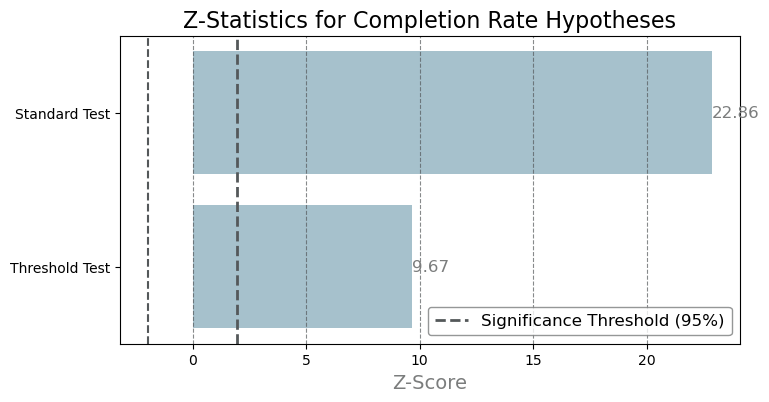

In [16]:
sns.set_palette([vanguard_red, vanguard_gray, vanguard_light_gray])

z_scores = [z_stat, z_stat_threshold]
labels = ['Standard Test', 'Threshold Test']

plt.figure(figsize=(8, 4))
sns.barplot(x=z_scores, y=labels)
plt.axvline(x=1.96, color=vanguard_light_gray, linestyle='--', label='Significance Threshold (95%)', linewidth=2)  # 95% confidence
plt.axvline(x=-1.96, color=vanguard_light_gray, linestyle='--')
for i, z in enumerate(z_scores):
    plt.text(z, i, f'{z:.2f}', color=vanguard_gray, va='center', ha='left' if z > 0 else 'right', fontsize=12)
plt.title('Z-Statistics for Completion Rate Hypotheses', fontsize=16)
plt.xlabel('Z-Score', fontsize=14, color=vanguard_gray)
plt.legend(fontsize=12, facecolor='white', frameon=True, edgecolor=vanguard_gray)
plt.grid(axis='x', linestyle='--', color=vanguard_light_gray, alpha=0.7)
plt.show()

<h1 style="color: #8B2331;">2 Hypothesis Error Rate</h1>

In [18]:
# Error rates (users moving backward)
df['step_order'] = df['process_step'].cat.codes
df['step_diff'] = df.groupby(['client_id', 'session_id'])['step_order'].diff()
error_rate = df[df['step_diff'] < 0].groupby('control_test')['client_id'].nunique() / total_users * 100
error_rate.round(2)

control_test
Control    62.70
Test       65.41
dtype: float64

In [19]:
# Error counts (unique users with backward steps) and total users (unique clients)
error_counts = [error_rate['Test'], error_rate['Control']]
nobs = [total_users['Test'], total_users['Control']]

# Z-test for error rates
z_stat_error, p_value_error = proportions_ztest(error_counts, nobs, alternative='two-sided')

print(f"Z-Statistic for Error Rate: {z_stat_error:.4f}")
print(f"P-Value for Error Rate: {p_value_error:.4e}")

Z-Statistic for Error Rate: -0.5702
P-Value for Error Rate: 5.6851e-01


In [20]:
control_error_rate = error_rate['Control']
threshold = control_error_rate + 5  # Adding 5% to the Control group error rate
print(f"Threshold (Control + 5%): {threshold:.2f}")

Threshold (Control + 5%): 67.70


In [21]:
z_stat_error_threshold, p_value_error_threshold = proportions_ztest(
    error_counts,  # The number of errors for each group
    nobs,          # The total number of observations (users)
    value=threshold,  # The threshold (Control group error rate + 5%)
    alternative='larger'  # Test if Test group > Control group + 5%
)

print(f"Z-Statistic for Error Rate (Threshold): {z_stat_error_threshold:.4f}")
print(f"P-Value for Error Rate (Threshold): {p_value_error_threshold:.4e}")

Z-Statistic for Error Rate (Threshold): -206988.8349
P-Value for Error Rate (Threshold): 1.0000e+00


<h1 style="color: #8B2331;">3 Hypothesis Balance</h1>

In [23]:
control_balance = df[df['control_test'] == 'Control']['balance'].dropna()
test_balance = df[df['control_test'] == 'Test']['balance'].dropna()

t_stat, p_value = ttest_ind(control_balance, test_balance)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -2.8212246502357416, P-value: 0.004784365844495117


<h1 style="color: #8B2331;">4 Hypothesis Client Tenure between Test and Control</h1>

In [25]:
group_test = df[df['control_test'] == 'Test']['tenure_mo']
group_control = df[df['control_test'] == 'Control']['tenure_mo']

group_control = group_control.dropna()
group_test = group_test.dropna()

print(f"Group Test Size: {len(group_test)}")
print(f"Group Control Size: {len(group_control)}")

print(group_test.dtype)
print(group_control.dtype)

if len(group_test) > 0 and len(group_control) > 0:
    t_stat, p_value = ttest_ind(group_test, group_control, equal_var=False)  # Welch's t-test
    print("Resultados de la prueba t:")
    print(f"Estadístico t: {t_stat}")
    print(f"p-valor: {p_value}")

    if p_value < 0.05:
        print("Reject H₀: No significative difference in Tenure by Month between Control and Test.")
    else:
        print("We can´t reject H₀: No significative evidence in Tenure by Month between Control and Test.")
else:
    print("Not enough data for the test.")

Group Test Size: 176699
Group Control Size: 140536
Int64
Int64
Resultados de la prueba t:
Estadístico t: 0.7424628110860118
p-valor: 0.4578075558115696
We can´t reject H₀: No significative evidence in Tenure by Month between Control and Test.


In [26]:
group_test = df[df['control_test'] == 'Test']['tenure_yr']
group_control = df[df['control_test'] == 'Control']['tenure_yr']

group_control = group_control.dropna()
group_test = group_test.dropna()

print(f"Group Test Size: {len(group_test)}")
print(f"Group Control Size: {len(group_control)}")

print(group_test.dtype)
print(group_control.dtype)

if len(group_test) > 0 and len(group_control) > 0:
    t_stat, p_value = ttest_ind(group_test, group_control, equal_var=False)  # Welch's t-test
    print("Resultados de la prueba t:")
    print(f"Estadístico t: {t_stat}")
    print(f"p-valor: {p_value}")

    if p_value < 0.05:
        print("Reject H₀: No significative difference in Tenure by Year between Control and Test.")
    else:
        print("We can´t reject H₀: No significative evidence in Tenure by Year between Control and Test.")
else:
    print("Not enough data for the test.")

Group Test Size: 176699
Group Control Size: 140536
Int64
Int64
Resultados de la prueba t:
Estadístico t: 0.571378440955128
p-valor: 0.5677435670796311
We can´t reject H₀: No significative evidence in Tenure by Year between Control and Test.
